In [11]:
import os,sys
from utils import *
sys.path.append('.')




# Data Loading
### Load the data from pickle file
### Remove Outliers
### Scaling/Normalization ?

In [12]:
lind = '/mnt/users/scratch/leo/scratch/converted_v7/0-20001-0-10393_CEUAS_merged_v1.nc'
station = 'Lindenberg(0-20001-0-10393)'
df = get_CUON_data(lind, var="85", merged=True, std_plev=True )

# Data pre-processing

# remove outliers
df = df[ np.abs(stats.zscore(df.drop(columns = ['time']  ) ) < 3).all(axis=1)]

# Remove missing values
df = df.dropna()
# MinMax scaling
#scaler = MinMaxScaler(feature_range=(0, 1))
#df = scaler.fit_transform(df)

10393_CEUAS_merged_v1.nc_85_.pkl
---Loading saved pickle file  10393_CEUAS_merged_v1.nc_85_.pkl


In [13]:
def make_grid_adjustment(df, station = '', hour ='0', all_levels= False):
    """ Plot the grid of temperature adjustments for a station on all pressure level """
    if all_levels:
        std =      [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000]
        lab = 'all'
        fig,axs = plt.subplots(len(std), figsize = (10,40), sharex=True)
        
    else:
        std =      [1000, 5000, 10000, 20000, 50000, 85000, 100000] # 10
        lab = 'small'
        fig,axs = plt.subplots(len(std), figsize = (10,15), sharex=True)


    if hour ==0:
        hour = '00'
    else:
        hour = '12'
        
    for p,num in zip(std, range(len(std)) ):

        r = df.loc[df['z'] == p]
        time = r['time']
        bias = r['bias']
        
        axs[num].plot(time, bias, label = str(int(p/100)) + ' [hPa]')
        axs[num].legend()
        axs[num].set_ylim([-3,1.5])
        
        #if num < len(std)-1:
        #    axs[num].set_xticks([])
            
        axs[num].set_ylabel("Bias [K]")
        axs[num].grid(ls=':', color = 'lightgray')

    #axs[0].set_title("Temperature Bias Adjustment " + station + ' - '  + str(hour) + 'Z', y =1.02)
    axs[0].set_title("Temperature Bias Adjustment " + station + ' - ', y =1.02)

    stat_name = station.replace(" ","-").replace("/","").replace("(","").replace(")","")
    
    #plt.savefig("Plots/bias/"+ stat_name + '/bias-grid_' +  station.replace("/","")  + '_' + str(hour) + '_' + lab +  '.png' , dpi=200)

    plt.show()
    

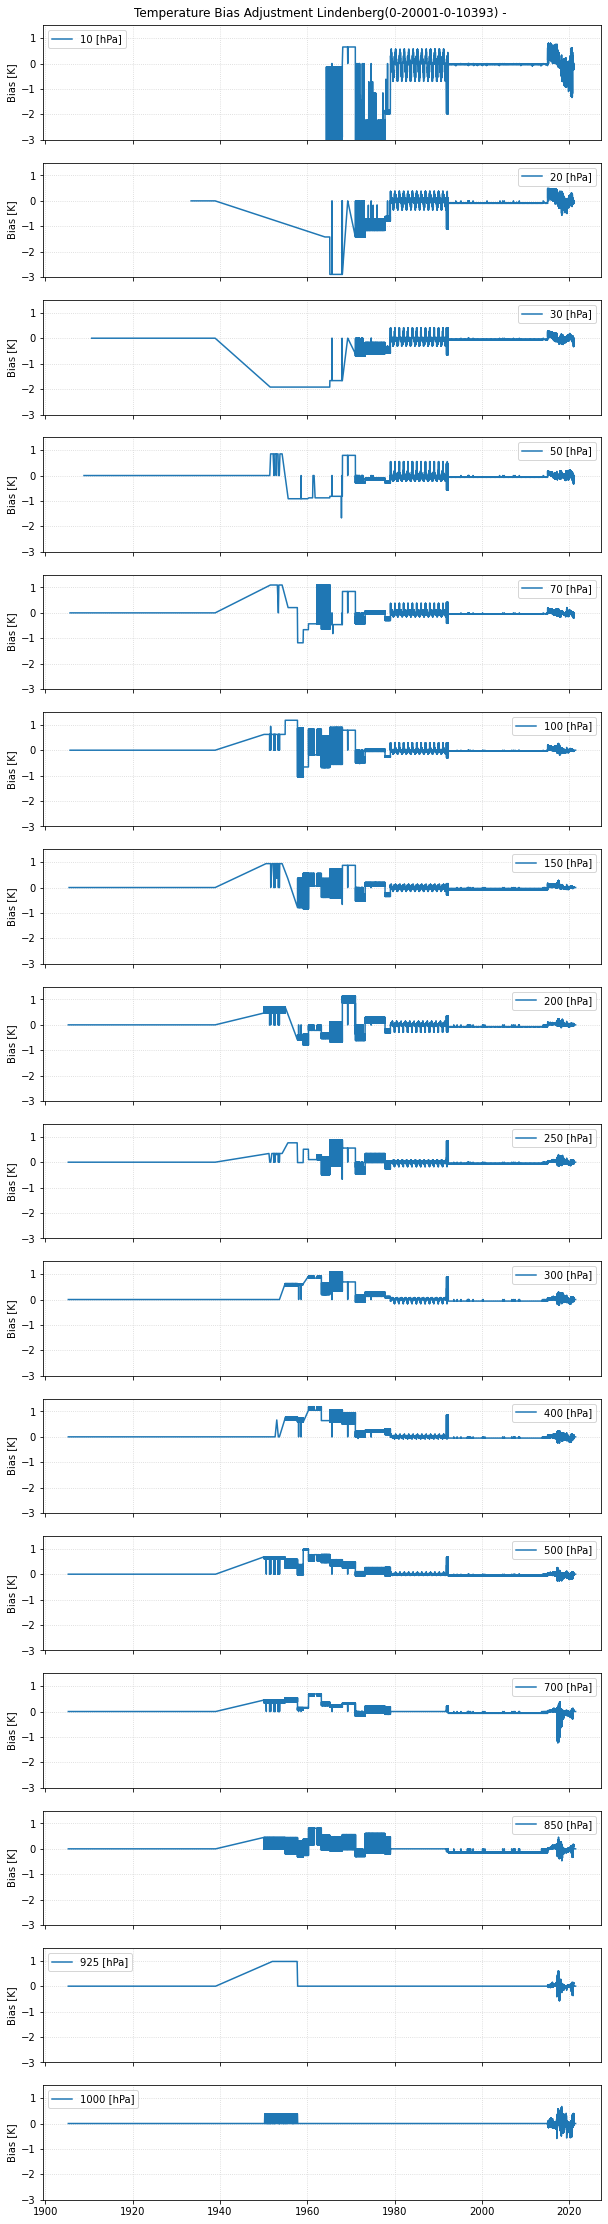

In [14]:
a = make_grid_adjustment(df, station = station, hour ='0', all_levels= True)

# Splitting into training and testing

In [15]:
#train_labels = ['fg_dep', 'fg_dep_adj','obs_adj','obs', 'an_dep', 'an_dep_adj', 'time'] 
#target_labels =  ['bias']

# Preparing training and testing data 
X_train_time, X_test_time, y_train, y_test = split_train_test_data(df, plevel = 85000, all_level=True)

# Removing time column from train and test
# For plotting must take time from the X_test and X_train, y_ do not contian time info 
X_train = X_train_time.drop(columns = ['time']) 
X_test = X_test_time.drop(columns = ['time']) 

#X_train.shape

# Look at the data 

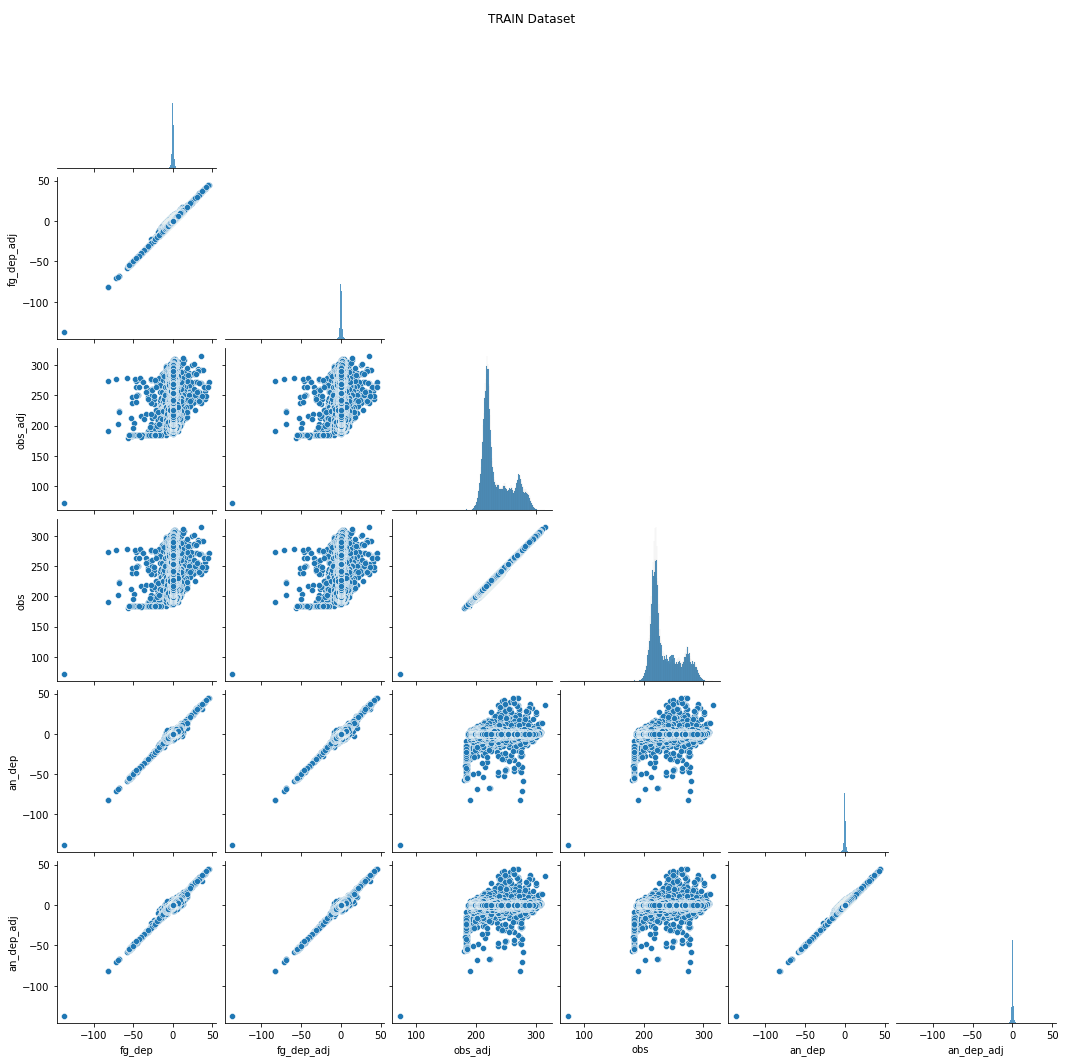

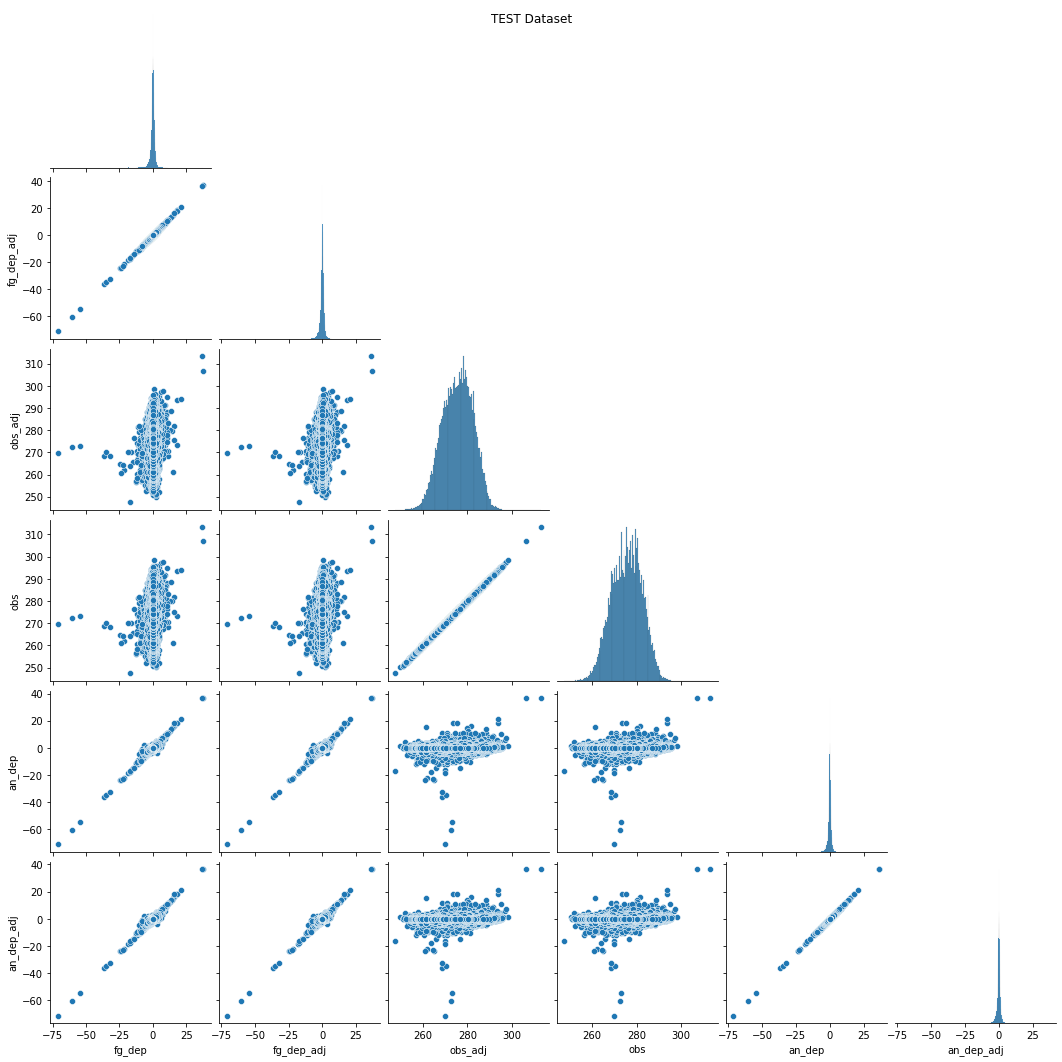

In [16]:
dummy = make_seaborn_scattermatrix(X_train, title='TRAIN Dataset')
dummy = make_seaborn_scattermatrix(X_test, title='TEST Dataset')

In [23]:
def make_regression( X_train, X_test, y_train, y_test, regressor = 'rf', epochs = 10):
    """ Use different types of regressors and train the model.
        Return the prediction for the choosen regressor.
    
        Parameters:
                regressor(str):  type of regression ['rf': random forest , ]
            

        Return:
                regressor prediction
                    
    """
    
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.datasets import make_regression
    from sklearn.model_selection import train_test_split

    from sklearn.tree import DecisionTreeRegressor

    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM

    
    # Fitting Models
    if regressor == 'rf': # random forest 

        model = RandomForestRegressor(max_depth=2, 
                                    random_state=0,
                                    bootstrap=True,
                                    max_samples=0.7,
                                                   )
        model.fit(X_train, y_train)
        
    elif regressor == 'dt': # decision tree
        # Fit regression model
        model = DecisionTreeRegressor(max_depth=100)
        model.fit(X_train, y_train)

    elif regressor == "lstm":
        
        # reshape the input for the LSTM implementation
        X_train, X_test = X_train.values[:,:], X_test.values[:,:] 
        
        print(X_test.shape)
        print(X_test.shape)
        print(X_test.shape[0] , X_test.shape[1])
        
        X_train_ = X_train.reshape( (X_train.shape[0], 1, X_train.shape[1] ))
        X_test  = X_test.reshape  ( (X_test.shape[0] , 1, X_test.shape[1]  ))

        model = Sequential()
        model.add(LSTM(epochs, input_shape=(X_train_.shape[1], X_train_.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        
        history = model.fit(X_train_, y_train, epochs=epochs, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

    elif regressor == 'var':
        # need a complete input for VAR including time as a index, adding back bias 

        
        #print(y_train  )
        #print(X_train  )
        #print(y_test  )
        #print(X_test  )
        
        X_train['bias'] = y_train['bias']
        X_test['bias'] = y_test['bias']
        
        #print(X_test  )
        #print(X_train  )

        X_train_new = X_train.drop(columns = ['time'])
        X_train_new.index = X_train.time
        X_train_new = X_train_new.dropna()
        
        X_test_new = X_test.drop(columns = ['time'])
        X_test_new.index = X_test.time        
        X_test_new = X_train_new.dropna()
        
        #print(X_train_new.head, X_test_new.head)

        model = VAR(endog=X_train_new)
        model_fit = model.fit()
        prediction = model_fit.forecast(model_fit.y, steps=len(y_test))  # array of shape (len(X_train_new) , #columns) e.g. [1025118,8]


             
    
    # Making predictions 
    if regressor in ['dt', 'rf']:
        y_predict = model.predict(X_test)
        return y_predict 
    elif regressor == 'lstm':
        y_predict = model.predict(X_test)
        return y_predict, history 
    
    elif regressor == 'var':
    
        # convert to a dataframe
        pred_dic = {}
        print(X_test_new.columns)
        
        for i,ind in zip( X_test_new.columns, range( len(X_test_new.columns) ) ) :
            pred_dic[i] = [ col[ind] for col in prediction ]
        
        df_pred = pd.DataFrame(pred_dic)
        return df_pred 
        
        
        
        

# Training and predicting the result
### VAR model: https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/
Algorithms considered:
- decision tree (DT)
- random forest (RF)
- LSTM
- VAR (Vector Auto Regression)

Two approaches:
- do not consider time series data and try to find the relation between bias-an_dep-fg_dep-temp independently -> DT>, RF 
- consider time series information -> LSTM, VAR 

In [18]:
# Random forest
y_predict_rf = make_regression( X_train, X_test, y_train, y_test, regressor = 'rf')

<ipython-input-17-ec986750b4e7>:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


In [19]:
# Decision Tree
y_predict_dt = make_regression( X_train, X_test, y_train, y_test, regressor = 'dt')

(106933, 6)
(106933, 6)
106933 6
15359/15359 - 30s - loss: 0.1096 - val_loss: 0.1319


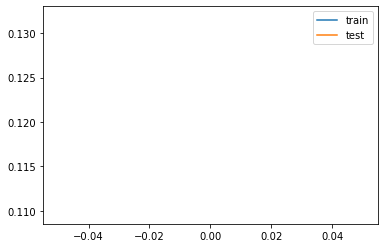

In [24]:
# LSTM
y_predict_lstm, history = make_regression( X_train, X_test, y_train, y_test, regressor = 'lstm' , epochs = 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [25]:
# VAR
y_prediction_VAR = make_regression( X_train_time, X_test_time, y_train, y_test, regressor = 'var')

/jetfs/home/federico/.conda/envs/RUN/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/jetfs/home/federico/.conda/envs/RUN/lib/python3.8/site-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Index(['fg_dep', 'fg_dep_adj', 'obs_adj', 'obs', 'an_dep', 'an_dep_adj',
       'bias'],
      dtype='object')


In [26]:
#y_prediction_VAR

# Aggregating the results 

In [27]:
results = pd.DataFrame( { 'time': X_test_time['time'].values,
                          'prediction_rf': y_predict_rf,
                          'prediction_dt': y_predict_dt,
                          'prediction_lstm': y_predict_lstm.flatten(),
                          'prediction_var': y_prediction_VAR['bias'].values,
                          'test' : y_test['bias'],                        
                        }  
                      )

#errors = abs(y_predict - y_test['bias'])

# Print out the mean absolute error (mae)
# print('Mean Absolute Error:', round(np.mean(errors), 2) )

In [28]:
plevel = 85000
title = 'Lindenberg ' + str(plevel) + ' hPa'

#dummy = make_plot(X_train_time , y_train, results, title = title, zoom = False )
#dummy = make_plot(X_train_time , y_train, results, title = title, zoom = True )


In [43]:
def plot_results(algo='dt', zoom=True, plot_type = 'scatter', all_models=False):
    
    dic = { 'dt': { 'name': 'Decision Tree',
                    } ,
           
           'rf' :  { 'name': 'Random Forest',
                    } ,
           
           'lstm': { 'name': 'LSTM',
                    } ,
           
           'var': { 'name': 'VAR',
                    } ,          
           
          }
    
    fs = 15
    plt.figure(figsize=(15,8))

    if not all_models:
        fig, axs = plt.subplots(2,1,figsize=(20,10), gridspec_kw={'height_ratios': [4, 1]} , sharex=True)

        if  plot_type == 'scatter':
            axs[0].scatter( results['time'].values , results['prediction_' + algo ].values, label = dic[algo]["name"] + ' Bias ')
            axs[0].scatter( results['time'].values , results['test'].values, label = 'Test Bias ')
            #axs[0].scatter( X_train_time['time'].values , y_train['bias'].values, label = 'Observed Bias ')

        else:
            axs[0].plot( results['time'].values , results['prediction_' + algo ].values, label = dic[algo]["name"] + ' Bias ')
            axs[0].plot( results['time'].values , results['test'].values, label = 'Test Bias ')
            #axs[0].plot( X_train_time['time'].values , y_train['bias'].values, label = 'Observed Bias ')

        axs[1].plot( results['time'].values,   results['prediction_' + algo ].values - results['test'].values, label = 'Pred-Test'  )
        axs[1].set_ylabel('Pred-Test', fontsize = fs)

        #plt.plot( results['time'].values , results['prediction_rf'].values, label = 'Random Forest Bias ')

        fig.suptitle(title, y=0.92, fontsize = fs)

        axs[0].set_ylabel("Bias [K]", fontsize = fs)
        axs[0].legend(fontsize = fs)

        axs[0].set_xlim(pd.Timestamp('19490101'), pd.Timestamp('20200101') )
        axs[1].set_xlim(pd.Timestamp('19490101'), pd.Timestamp('20200101') )
        
        if zoom:
            axs[0].set_xlim(pd.Timestamp('19950101'), pd.Timestamp('20200101') )
            axs[1].set_xlim(pd.Timestamp('19950101'), pd.Timestamp('20200101') )
            
    
    else:
        fig, axs = plt.subplots(2,1,figsize=(20,10) )
            
        axs[0].plot(results['time'].values , results['test'].values, label = 'Test Bias ' , color = 'black')

        for algo in dic.keys() :
            axs[0].plot( results['time'].values , results['prediction_' + algo ].values, label = dic[algo]["name"] + ' Bias ')
            axs[1].plot( results['time'].values,  results['prediction_' + algo ].values - results['test'].values, label = dic[algo]["name"] )

        #axs[0].scatter( X_train_time['time'].values , y_train['bias'].values, label = 'Observed Bias ')


        fig.suptitle(title, y=0.92, fontsize = fs)

        axs[0].set_ylabel("Bias [K]", fontsize = fs)
        axs[0].legend(fontsize = fs)

        axs[1].set_ylabel('Pred-Test', fontsize = fs)
        axs[1].legend(fontsize = fs)
        
        axs[0].set_xlim(pd.Timestamp('19490101'), pd.Timestamp('20200101') )
        axs[1].set_xlim(pd.Timestamp('19490101'), pd.Timestamp('20200101') )

        if zoom:
            axs[0].set_xlim(pd.Timestamp('19950101'), pd.Timestamp('20200101') )
            axs[1].set_xlim(pd.Timestamp('19950101'), pd.Timestamp('20200101') )


    plt.show()
    

<Figure size 1080x576 with 0 Axes>

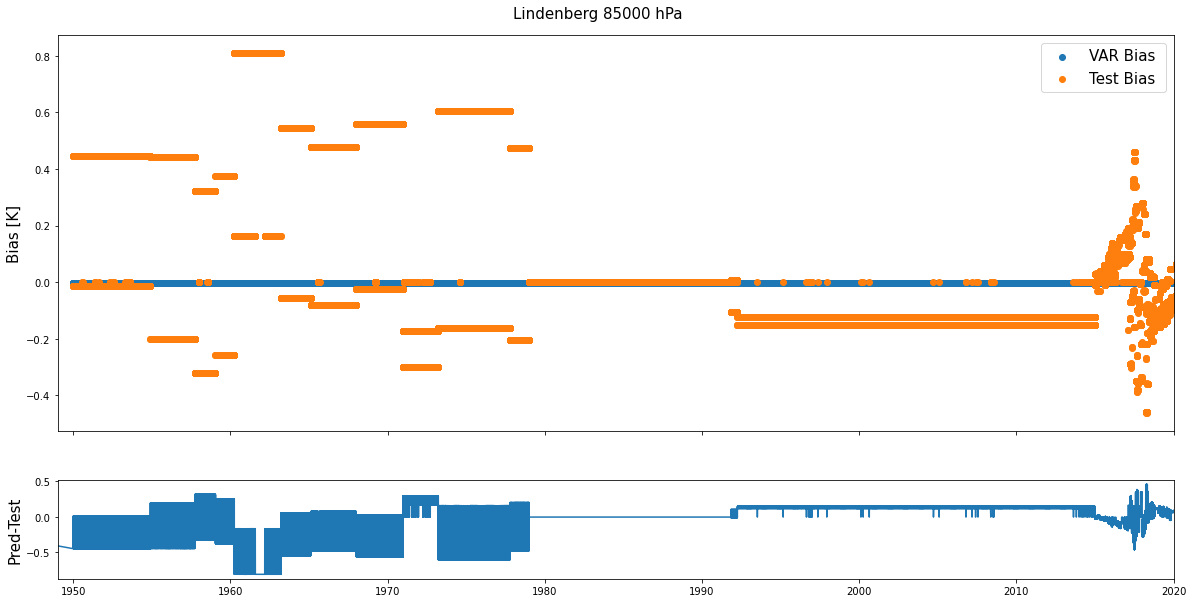

<Figure size 1080x576 with 0 Axes>

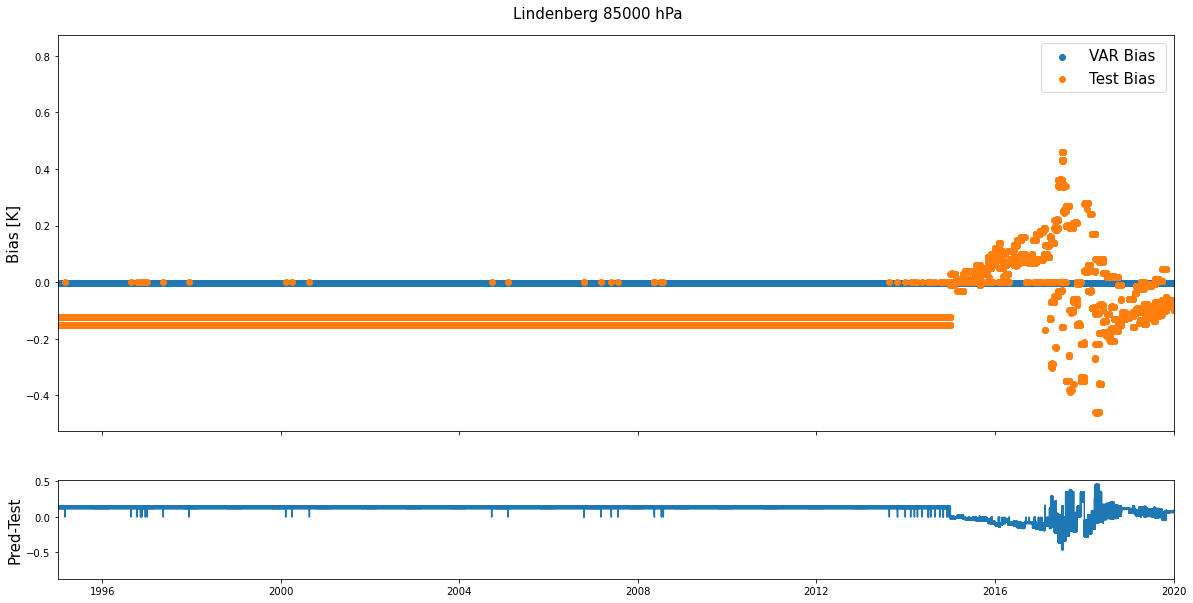

<Figure size 1080x576 with 0 Axes>

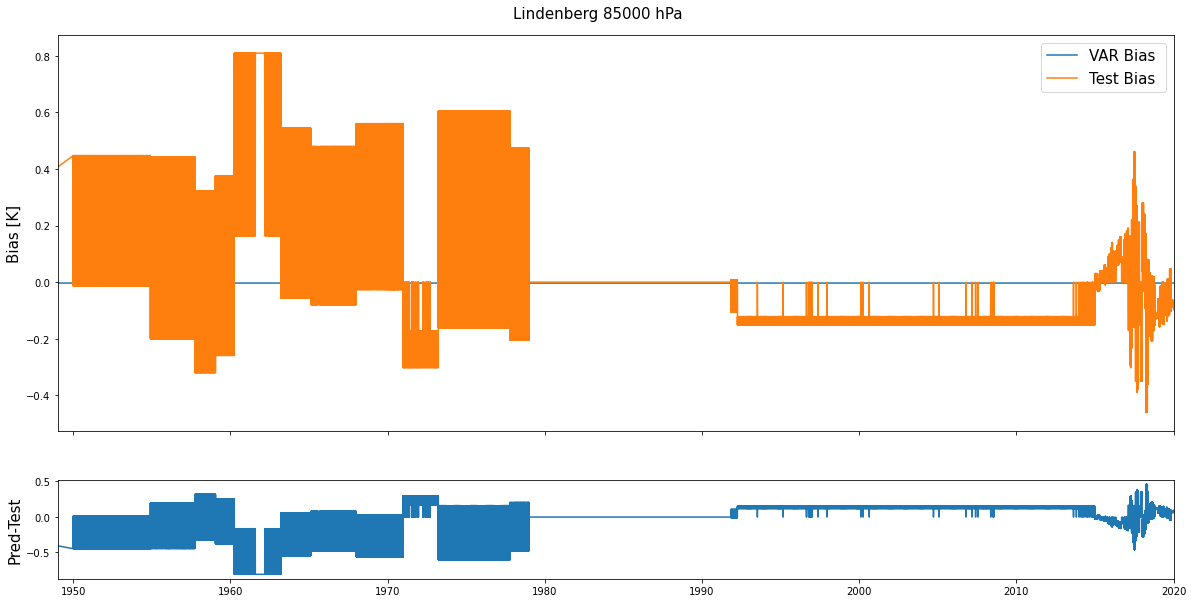

<Figure size 1080x576 with 0 Axes>

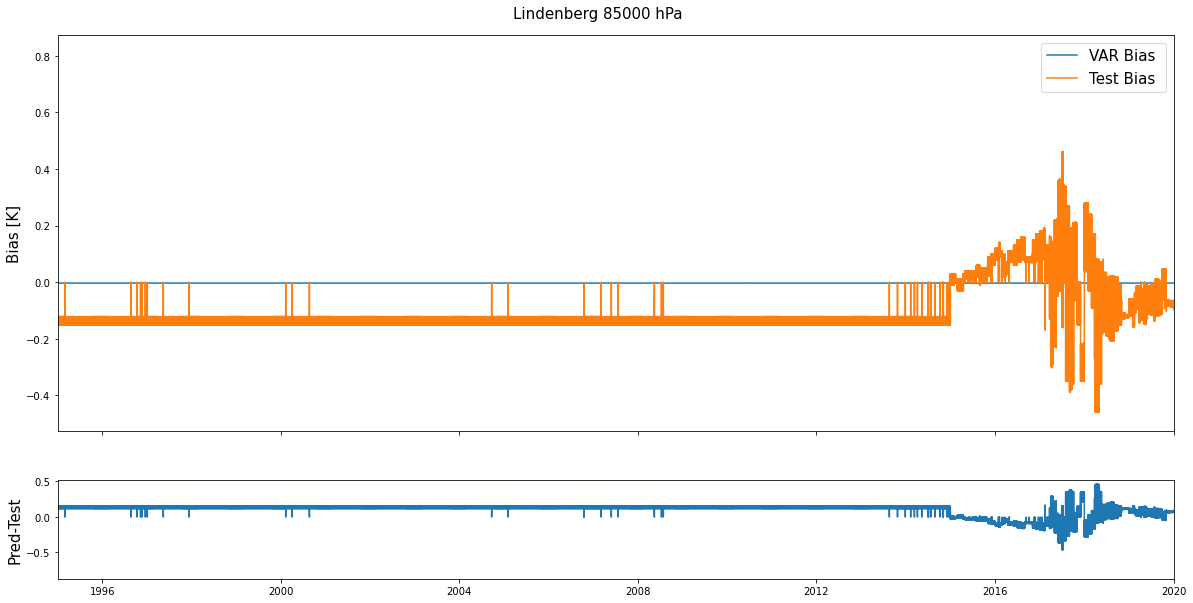

In [44]:
plot_results(algo='var', zoom=False)
plot_results(algo='var', zoom=True)
plot_results(algo='var', zoom=False, plot_type = 'line')
plot_results(algo='var', zoom=True , plot_type = 'line')

<Figure size 1080x576 with 0 Axes>

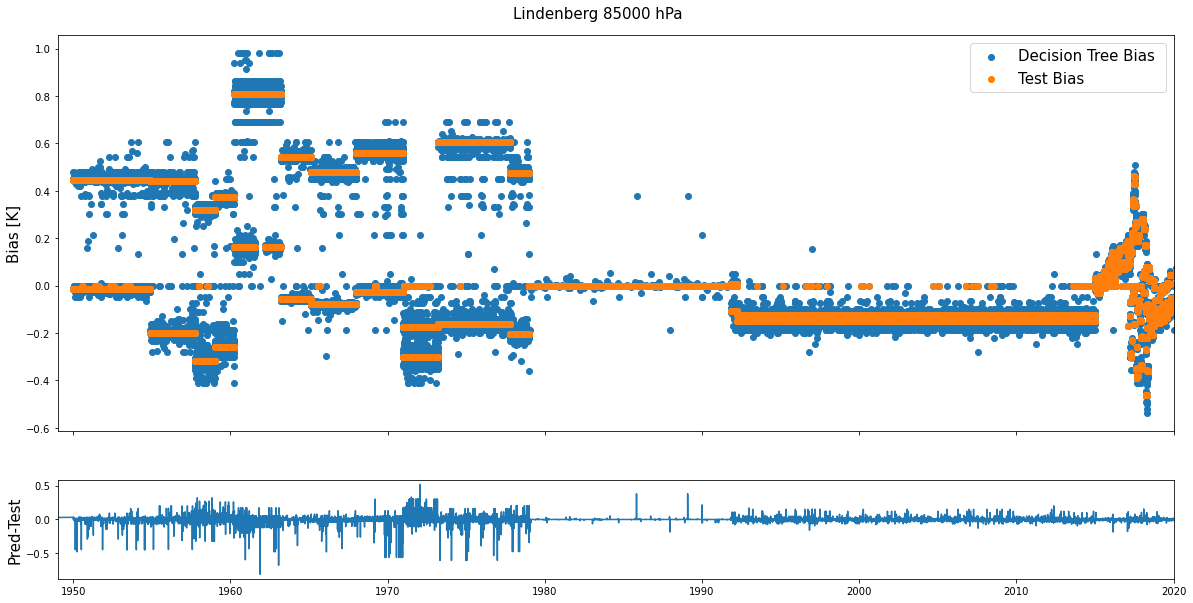

<Figure size 1080x576 with 0 Axes>

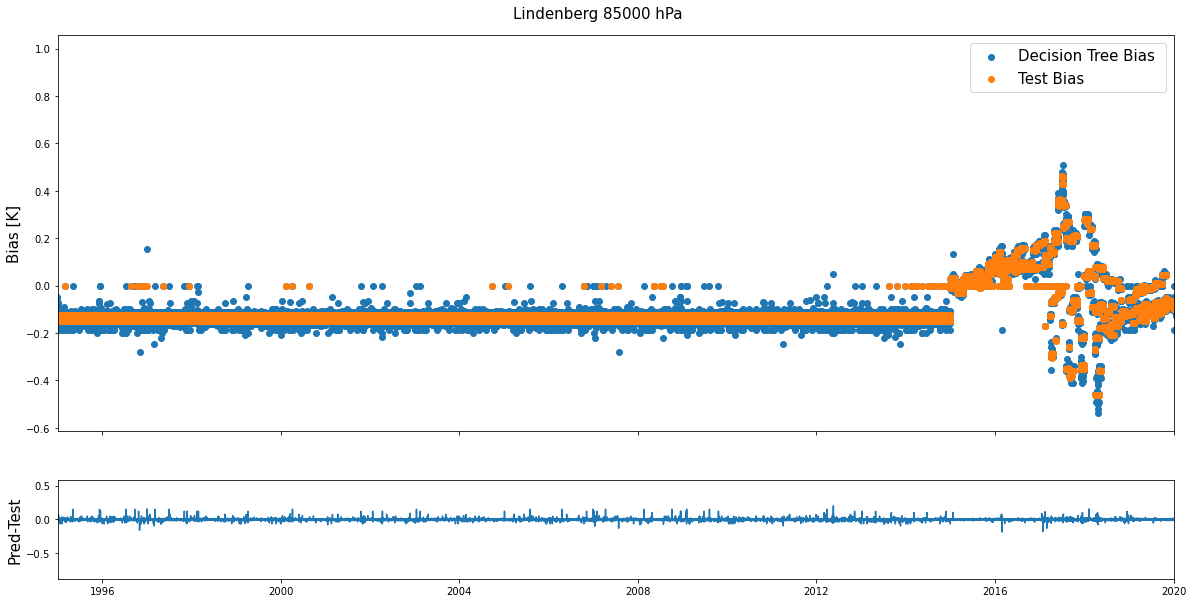

<Figure size 1080x576 with 0 Axes>

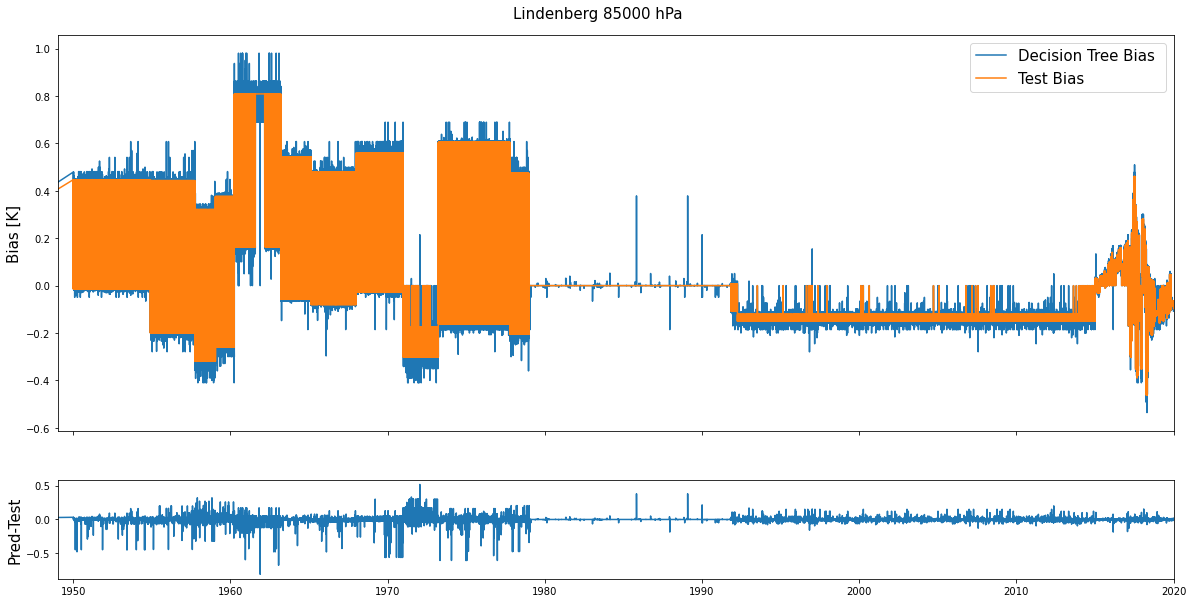

<Figure size 1080x576 with 0 Axes>

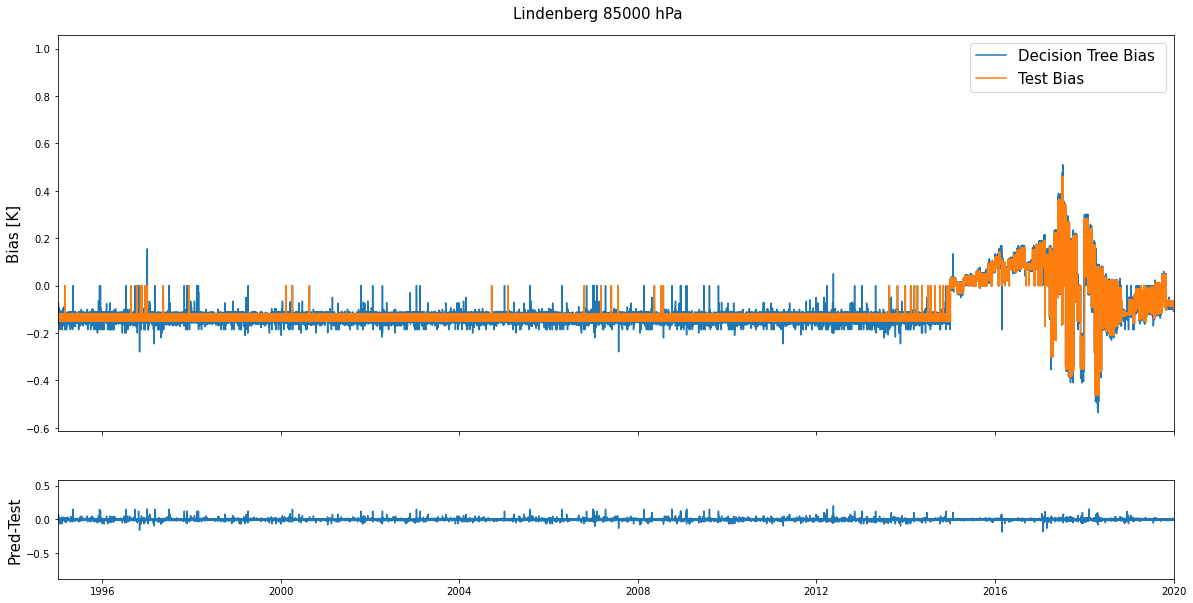

In [45]:
plot_results(algo='dt', zoom=False)
plot_results(algo='dt', zoom=True)
plot_results(algo='dt', zoom=False, plot_type = 'line')
plot_results(algo='dt', zoom=True , plot_type = 'line')

<Figure size 1080x576 with 0 Axes>

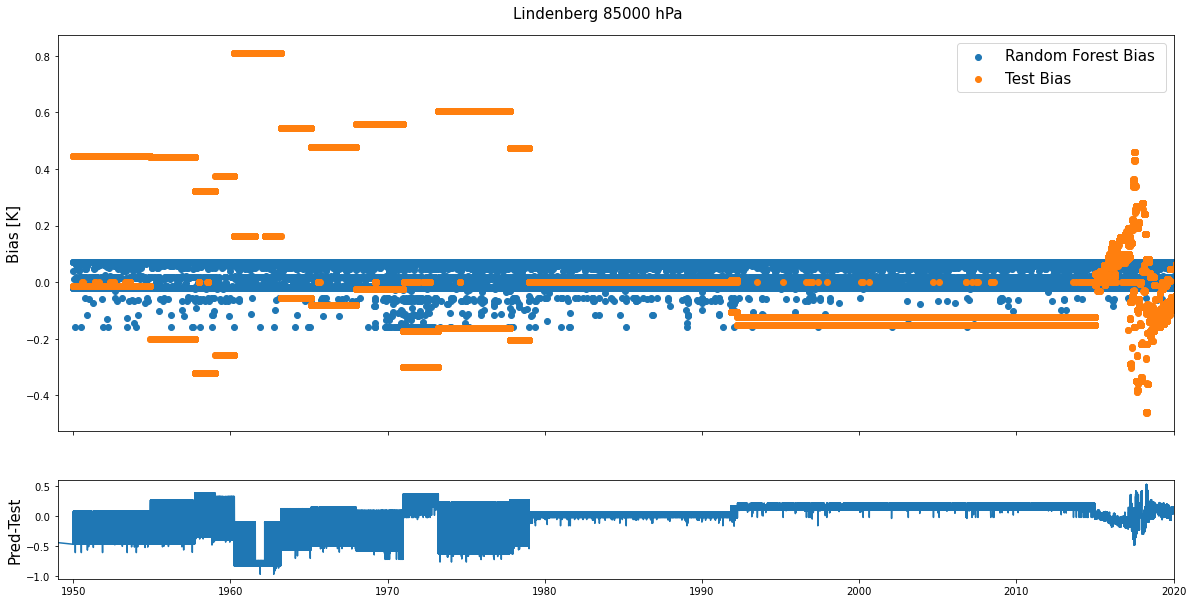

<Figure size 1080x576 with 0 Axes>

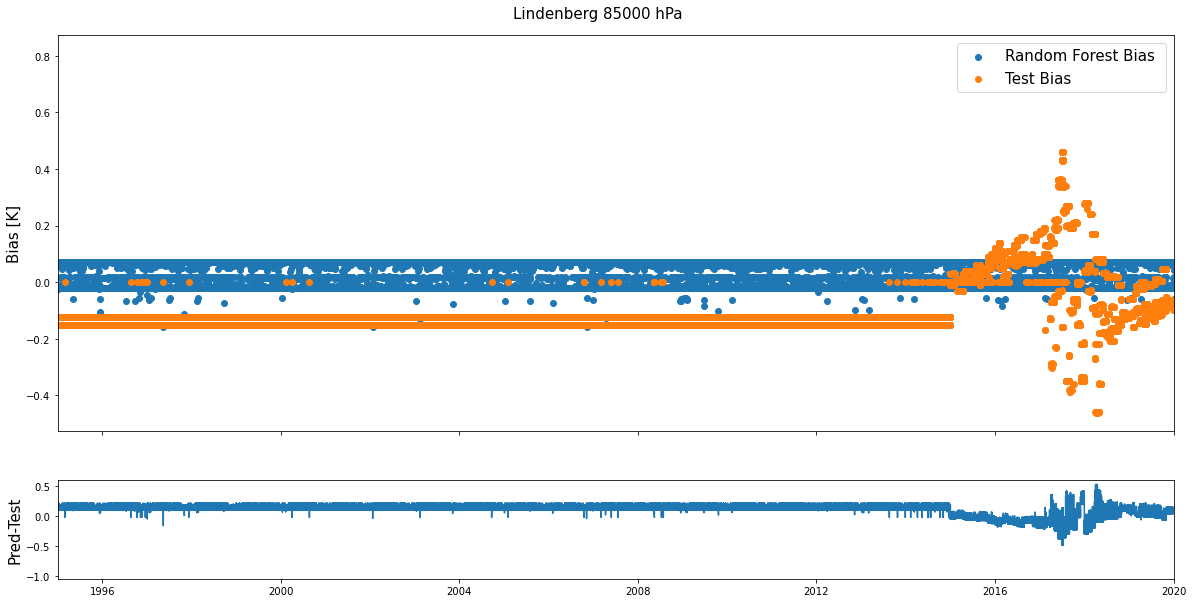

<Figure size 1080x576 with 0 Axes>

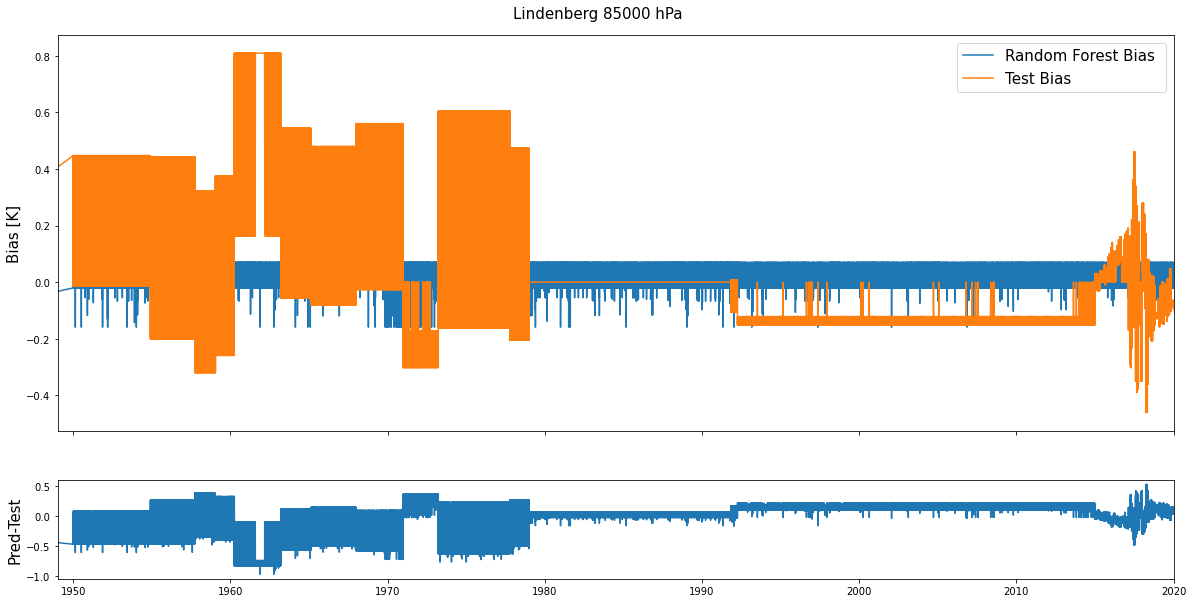

<Figure size 1080x576 with 0 Axes>

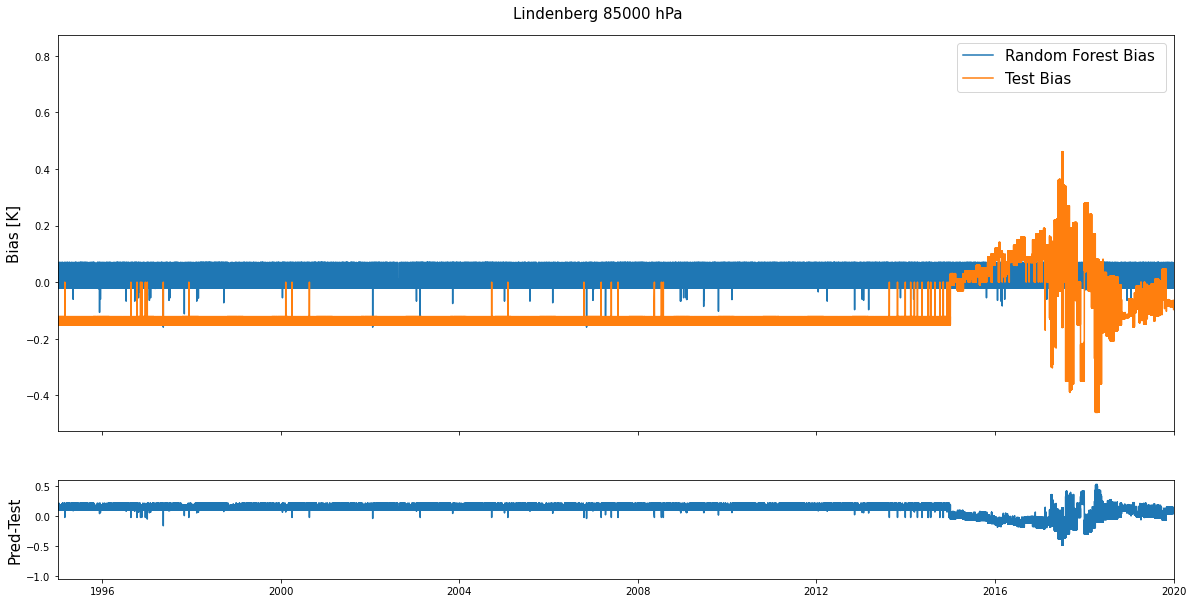

In [46]:
plot_results(algo='rf', zoom=False)
plot_results(algo='rf', zoom=True)
plot_results(algo='rf', zoom=False, plot_type = 'line')
plot_results(algo='rf', zoom=True , plot_type = 'line')

<Figure size 1080x576 with 0 Axes>

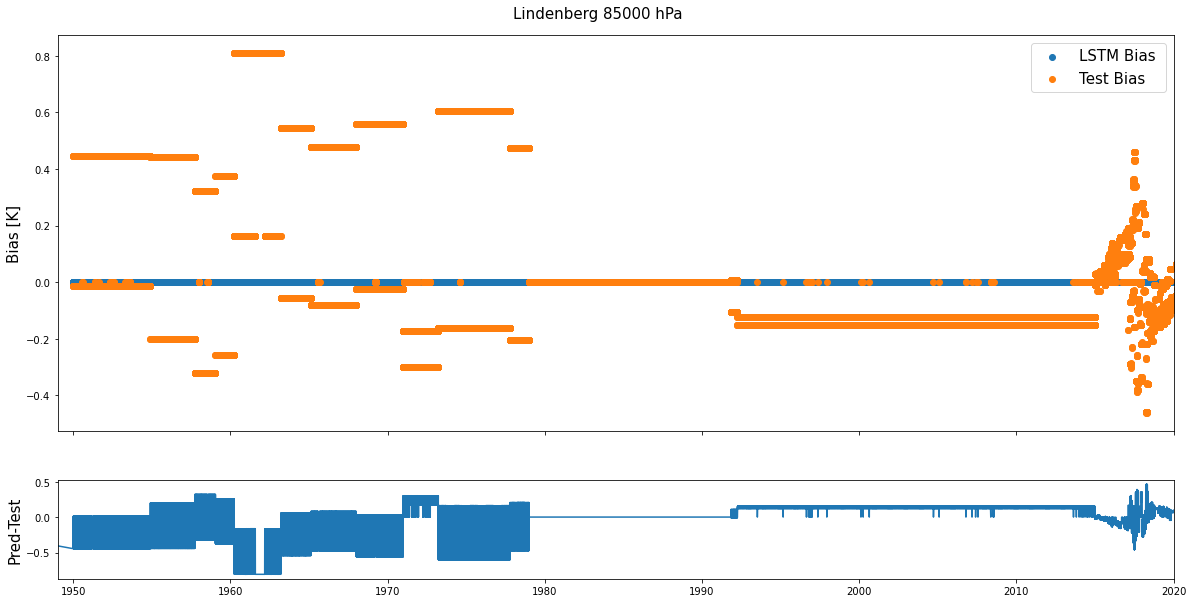

<Figure size 1080x576 with 0 Axes>

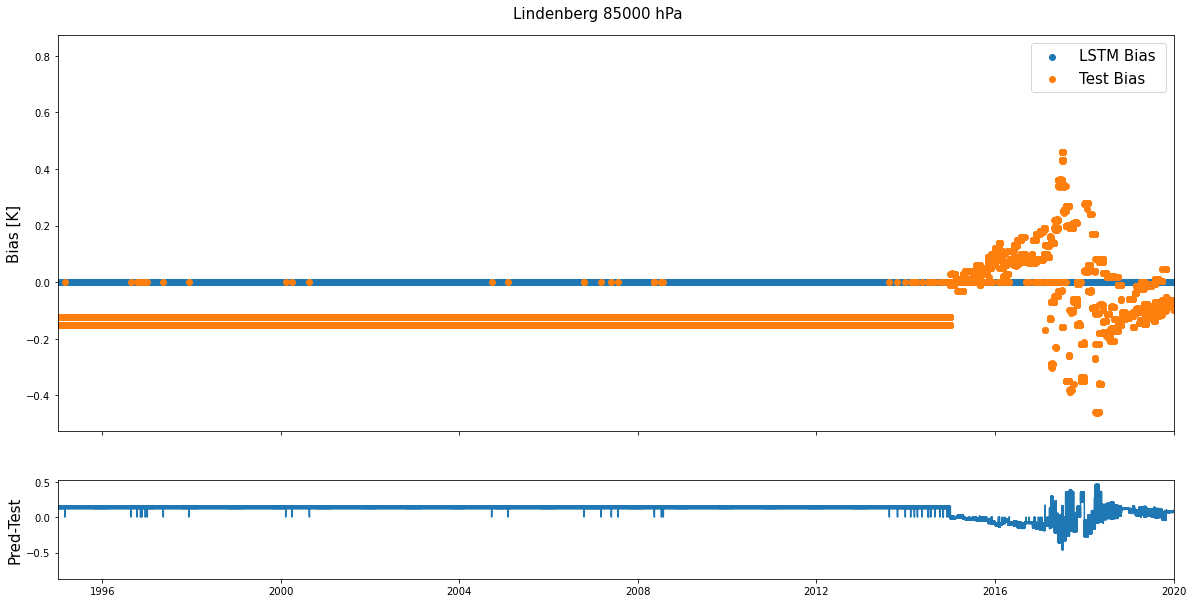

<Figure size 1080x576 with 0 Axes>

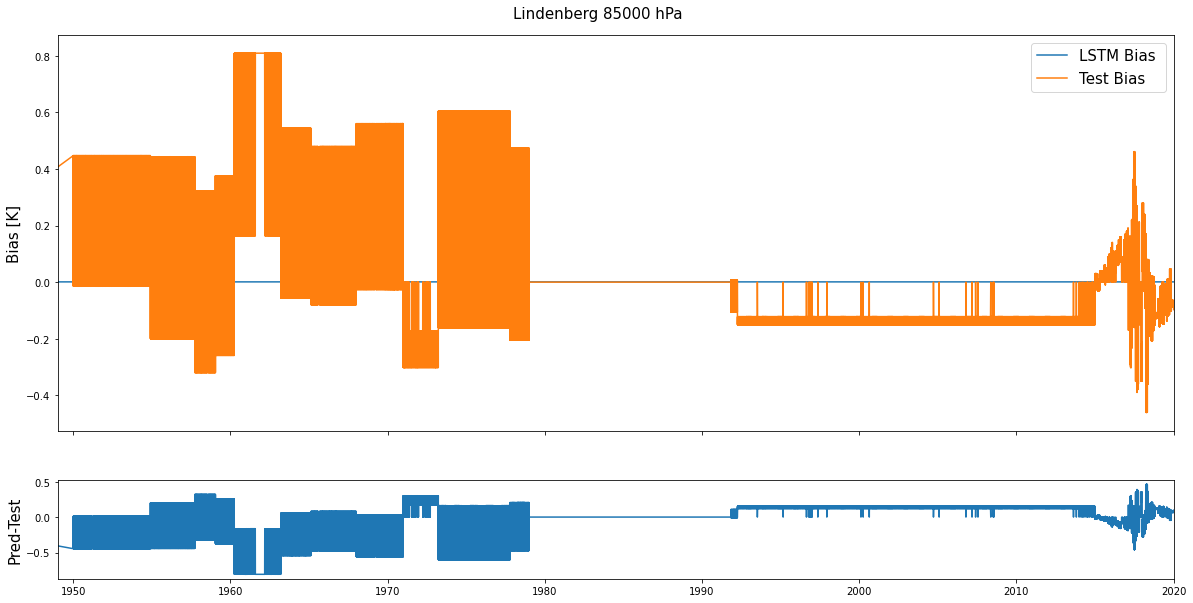

<Figure size 1080x576 with 0 Axes>

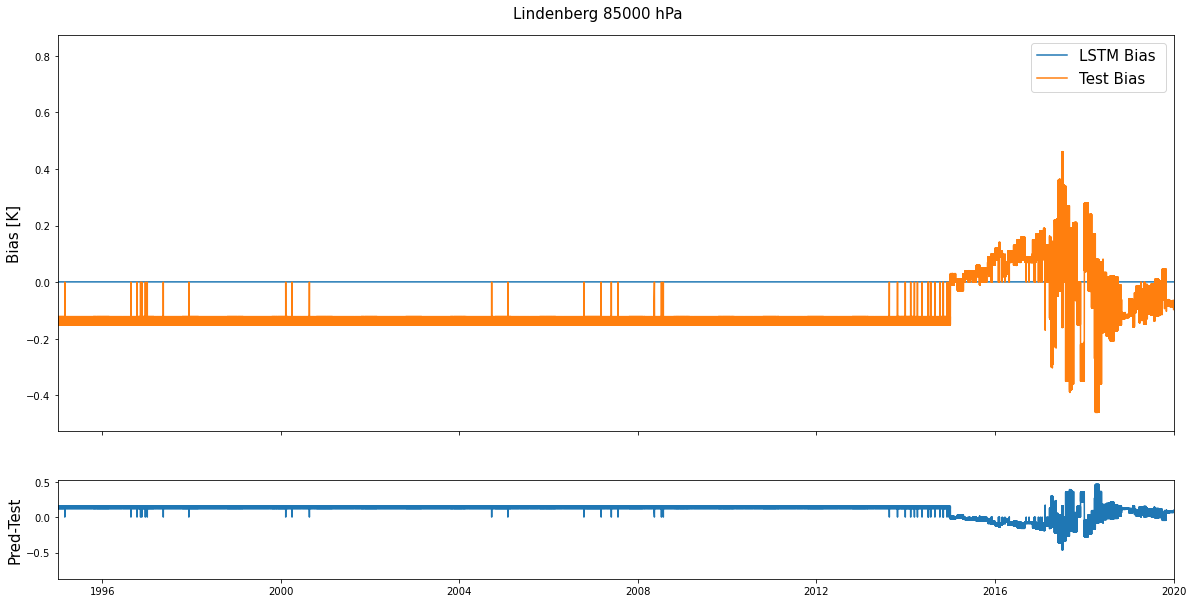

In [47]:
plot_results(algo='lstm', zoom=False)
plot_results(algo='lstm', zoom=True)
plot_results(algo='lstm', zoom=False, plot_type = 'line')
plot_results(algo='lstm', zoom=True , plot_type = 'line')

<Figure size 1080x576 with 0 Axes>

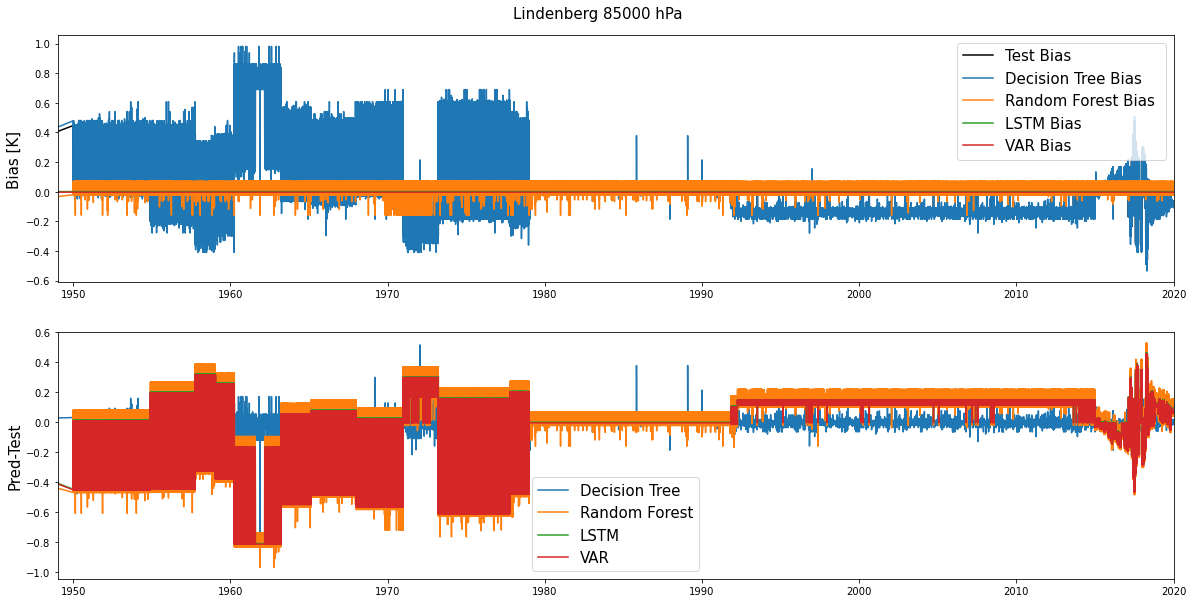

In [48]:
plot_results(zoom=False, all_models=True)
